In [1]:
import wrds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

db = wrds.Connection(wrds_username='edvardc')

Loading library list...
Done


(a)

In [2]:
#loading data
mkt = db.raw_sql("select date, vwretd from crsp.msi where date>='1970-01-01' and date<='2019-12-31'", date_cols=['date'])
stocksraw = db.raw_sql("select a.date, a.ret, a.prc, a.shrout, a.permno from crsp.msf as a left join crsp.msenames as b on a.permno=b.permno and b.namedt<=a.date and b.nameendt>=a.date where a.date>='1970-01-01' and a.date<='2019-12-31' and b.shrcd in (10, 11) and b.exchcd in (1, 2)", date_cols=['date'])
factors = pd.read_csv('F-F_Research_Data_Factors.csv', index_col = 0, nrows=1122)
mom = pd.read_csv('F-F_Momentum_Factor.csv', skiprows = 13, index_col = 0, nrows=1116)

In [8]:
#leaving stocks with full data only
length = stocksraw.groupby(['permno']).agg(['count'])['date']
stocks = stocksraw[stocksraw['permno'].isin(length[length['count'] == 600].index)]
print('Number of stocks with 600 values: ', len(np.unique(stocks.permno)))

Number of stocks with 600 values:  213


In [9]:
print('Stocks with at least one NA value: ')
print(stocks.permno[stocks.ret.isna()].values)

#dropping NA
np.unique(stocks.permno[stocks.ret.isna()].values)
stocks = stocks[~stocks['permno'].isin(stocks.permno[stocks.ret.isna()].values)]

Stocks with at least one NA value: 
[20415. 29209. 29612. 29938. 30509. 31691. 35107. 35107. 35991. 36281.
 36281. 39693. 39693. 42585. 45225. 46068. 46834. 46834. 47626. 47626.
 49138.]


Stocks with at least one NA value were removed from analysis.

In [10]:
print('Number of stocks with 600 values and without NA: ', len(np.unique(stocks.permno)))

Number of stocks with 600 values and without NA:  197


In [11]:
#deleting unnecessary rows and transforming factors
stocks.date = pd.to_datetime(stocks['date'])
factors = factors[factors.index >= np.min(stocks.index)]
factors = factors / 100
mom = mom[mom.index >= np.min(stocksraw.index)]
factors['MOM'] = mom / 100

In [12]:
#calculating market cap.
stocks['mktcap'] = np.abs(stocks['prc']) * stocks['shrout']

In [28]:
#preparing data frames for sorting into deciles
dates = np.unique(stocks.date)
deciles_b = np.zeros(((len(dates)-12)*len(np.unique(stocks.permno)), 1))
deciles_c = np.zeros(((len(dates)-12)*len(np.unique(stocks.permno)), 1))
stocks_sorted = stocks.sort_values(by=['date', 'permno'])

#sorting data into deciles for parts b) and c)
#for part b) we calculate the average return of the stock between months t-12 and t-2 (including them)
#we exclude first 12 months of time series from analysis (year 1970), because of the calculation of the rolling return
i = 0
j = 0
for date in dates[12:]:
    temp_df = stocks_sorted[(stocks_sorted.date >= dates[j]) & (stocks_sorted.date <= dates[j+10])]
    roll_ret = pd.DataFrame(temp_df[['ret', 'permno']].groupby(['permno']).agg(["mean"])['ret'])
    #9 - highest market cap, 0 - lowest
    deciles_b[i:i + len(np.unique(stocks_sorted.permno))] = pd.DataFrame(pd.qcut(roll_ret['mean'], 10).cat.codes)
    #1 - highest market cap, 0 - lowest
#     deciles_c[i:i + len(np.unique(stocks_sorted.permno))] = pd.DataFrame(pd.qcut(roll_ret['mean'], 2).cat.codes)
    deciles_c[i:i + len(np.unique(stocks_sorted.permno))] = pd.DataFrame(pd.qcut(stocks_sorted[stocks_sorted.date == dates[11 + j]].mktcap, 2).cat.codes)
    i = i + len(np.unique(stocks_sorted.permno))
    j = j + 1

In [29]:
#assigning deciles to stocks data
stocks_cut = stocks_sorted[stocks_sorted.date >= np.min(dates[12:])]
factors = factors[factors.index >= np.min(stocks_cut.date.map(lambda x: 100*x.year + x.month))]
mkt = mkt[mkt.date >= np.min(stocks_cut.date)]

deciles_b = pd.DataFrame(deciles_b, index = stocks_cut.index, columns = ['deciles_b'])
deciles_c = pd.DataFrame(deciles_c, index = stocks_cut.index, columns = ['deciles_c'])
stocks_cut = stocks_cut.merge(deciles_b, on = stocks_cut.index, how = 'left').drop(['key_0'], axis=1)
stocks_cut = stocks_cut.merge(deciles_c, on = stocks_cut.index, how = 'left').drop(['key_0'], axis=1)

In [30]:
#calculating value weighted returns
#calculating zero cost portfolio returns
#saving alphas and t-values

avg_vw_ret = []
zero_c_ret = []
alpha = []
tvalue = []
i = 0
for sorting in ['deciles_b', 'deciles_c']:
    #vw monthly returns
    tot_mktcap = pd.DataFrame(stocks_cut.groupby([sorting, 'date']).agg(["sum"])['mktcap']['sum'])
    tot_mktcap['date'], tot_mktcap[sorting] = tot_mktcap.index.get_level_values('date'), tot_mktcap.index.get_level_values(sorting)
    tot_mktcap = tot_mktcap.reset_index(drop=True)
    tot_mktcap.columns = ['tot_mktcap', 'date', sorting]
    
    #shifting market cap. time series by a month
    tot_mktcap['tot_mktcap'] = tot_mktcap.groupby([sorting])['tot_mktcap'].shift(1)
    stocks_sorted_mktcap = stocks_cut.merge(tot_mktcap, on = [sorting, 'date'], how = 'left')
    
    #deleting first date of time series from analysis
    stocks_sorted_mktcap = stocks_sorted_mktcap[~(stocks_sorted_mktcap.date == np.min(stocks_sorted_mktcap.date))]
    
    stocks_sorted_mktcap['mktcap_weight'] = stocks_sorted_mktcap['mktcap'] / stocks_sorted_mktcap['tot_mktcap']
    stocks_sorted_mktcap['vw_ret'] = stocks_sorted_mktcap['mktcap_weight'] * stocks_sorted_mktcap['ret']
    
    pf_vw_m_ret = pd.DataFrame(stocks_sorted_mktcap.groupby([sorting, 'date']).agg(["sum"])['vw_ret']['sum'])
    pf_vw_m_ret['date'], pf_vw_m_ret[sorting] = pf_vw_m_ret.index.get_level_values('date'), pf_vw_m_ret.index.get_level_values(sorting)
    pf_vw_m_ret = pf_vw_m_ret.reset_index(drop=True)
    pf_vw_m_ret.columns = ['vw_ret', 'date', sorting]

    avg_vw_ret.append(pf_vw_m_ret.groupby(sorting).agg(["sum"])['vw_ret']['sum'] / pf_vw_m_ret.groupby(sorting).agg(["count"])['vw_ret']['count'])
    zero_cost_m_ret = pf_vw_m_ret[pf_vw_m_ret[sorting] == np.max(pf_vw_m_ret[sorting])]['vw_ret'].values - pf_vw_m_ret[pf_vw_m_ret[sorting] == np.min(pf_vw_m_ret[sorting])]['vw_ret'].values

    y = zero_cost_m_ret
    if sorting == 'deciles_b':    
        X = np.column_stack((mkt.vwretd[1:], factors.SMB[1:], factors.HML[1:]))
    else:
        X = np.column_stack((mkt.vwretd[1:], factors.SMB[1:], factors.HML[1:], factors.MOM[1:]))
    X = sm.add_constant(X)
    model = sm.OLS(endog=y, exog=X, missing='drop').fit()
    alpha.append(model.params[0])
    tvalue.append(model.tvalues[0])
    zero_c_ret.append(np.mean(zero_cost_m_ret))
    
    i = i + 1

In [31]:
rets_table1 = pd.DataFrame({
                    'Avg. return (%)' : np.multiply(avg_vw_ret[0].values, 1200)
                      }, index = np.arange(1,11))
print('\nb) Annualized average monthly value weighted returns of decile portfolios. Portfolio 1 - decile with lowest market capitalization stocks, portfolio 10 - with highest market capitalization stocks.')
display(np.around(rets_table1,3))


b) Annualized average monthly value weighted returns of decile portfolios. Portfolio 1 - decile with lowest market capitalization stocks, portfolio 10 - with highest market capitalization stocks.


,Avg. return (%)
1,20.379
2,19.732
3,19.077
4,21.265
5,15.303
6,20.687
7,20.267
8,23.227
9,21.786
10,26.603


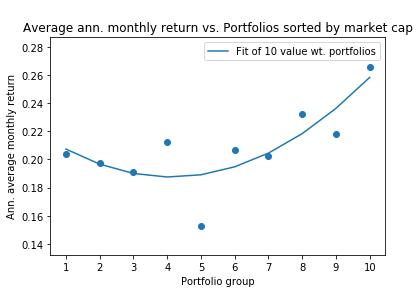

In [32]:
#plot
x = np.arange(1,11)
y = avg_vw_ret[0].values * 12
plt.scatter(x, y)
plt.ylabel('Ann. average monthly return')
plt.xlabel('Portfolio group')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 2))(np.unique(x)), label = 'Fit of 10 value wt. portfolios')
plt.legend()
plt.title('\nAverage ann. monthly return vs. Portfolios sorted by market cap')
# plt.ylim(0.06, 0.25)
plt.xticks(np.arange(min(x), max(x)+1, 1))
plt.show()

We observe that the relation between average monthly return of value weighted portfolios and the market capitalization is quadratic: as the market cap. increases, firstly, the return decreases, then goes up as we reach the top market capitalization portfolios. The highest return appears for the portfolio with highest market cap. stocks. Comments on zero cost portfolio are given in part c).

In [33]:
rets_table2 = pd.DataFrame({
                    'Avg. return (%)' : np.multiply(avg_vw_ret[1].values, 1200)
                      }, index = np.arange(1,3))
print('\nc) Annualized average monthly value weighted returns of decile portfolios. Portfolio 1 - decile with lowest market capitalization stocks, portfolio 2 - with highest market capitalization stocks.')
display(np.around(rets_table2,3))


c) Annualized average monthly value weighted returns of decile portfolios. Portfolio 1 - decile with lowest market capitalization stocks, portfolio 2 - with highest market capitalization stocks.


,Avg. return (%)
1,26.025
2,17.226


In [21]:
table = pd.DataFrame({
                    'Avg. return (%)' : np.multiply(zero_c_ret, 1200),
                    'Alpha' : np.multiply(alpha, 12), 
                    't-value' : tvalue
                      }, index = ['Part b)', 'Part c)'])
print('\nAnnualized statistics of the zero cost strategy')
display(np.around(table,3))


Annualized statistics of the zero cost strategy


,Avg. return (%),Alpha,t-value
Part b),6.224,0.124,2.518
Part c),-8.800,-0.071,-6.653


For part b) the zero-cost strategy alpha is positive and statistically significant (indicated by absolute value of t-value > 2). This means that the Fama-French factors (market return, SMB and HML) do not fully capture the returns of this zero-cost strategy.

In part c) the zero-cost strategy alpha is negative and also statistically significant. Thus, we can reject the hypothesis that the returns of this zero-cost strategy portfolio are explained by the Carhart 4 factor model (market return, SMB, HML and momentum). Also, the return is much lower than the strategy in part b). Negative return means that smaller market cap. stocks outperform higher market cap. stocks on average.